# Stock-and-ETF-Prediction
Authors: Patrick Guo

Looking into a set of features that are based on market data to predict a stock is going to up or down stock price at least by +2% or -2% on next trading day.

Input features:
1. Daily price of a set of stock of OPEN, HIGH, LOW, CLOSE, (ADJ-CLOSE)
2. The key indexes: S&P 500, Nasdaq 100, Hang Seng Index,
3. may put additional features of technical indicators based on stock price

Performance Metric:
- Multi-Class log loss
- Accuracy
- Precision Recall, F1 Score

# Import Libraries
[Stock CSVs on Google Drive](https://drive.google.com/file/d/1KJWGDK7rCGNb97JzJn4odw2EgVlyS350/view?usp=sharing)

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from os import walk
import sys

import yfinance as yf

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
myFmt = mdates.DateFormatter('%d')

# Preprocessing + Feature Selection
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# Model Building
from keras.models import Sequential
from keras.layers import Dense, LSTM
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Data

In [7]:
path = "Sample Data/"
filenames = next(walk(path), (None, None, []))[2]
print("Number of Stocks:", len(filenames))
filenames[0:5]

Number of Stocks: 43


['TSLA_.csv', 'AAPL_.csv', 'JNJ_.csv', 'JPM_.csv', 'AMZN_.csv']

In [8]:
stock = pd.read_csv(path + filenames[1])
stock

,date,symbol,open,high,low,close,volume,turnover,preclose,risefall,risefallratio
0,2021-01-29 00:00:00,AAPL,135.83,136.74,130.21,131.96,2.356907e+10,0,137.09,-5.13,-3.74
1,2021-01-28 00:00:00,AAPL,139.52,141.99,136.70,137.09,1.985112e+10,0,142.06,-4.97,-3.50
2,2021-01-27 00:00:00,AAPL,143.43,144.30,140.41,142.06,2.008244e+10,0,143.16,-1.10,-0.77
3,2021-01-26 00:00:00,AAPL,143.60,144.30,141.37,143.16,1.405457e+10,0,142.92,0.24,0.17
4,2021-01-25 00:00:00,AAPL,143.07,145.09,136.54,142.92,2.248438e+10,0,139.07,3.85,2.77
...,...,...,...,...,...,...,...,...,...,...,...
195,2020-06-09 00:00:00,AAPL,332.14,345.61,332.01,343.99,1.260915e+10,0,333.46,10.53,3.16
196,2020-06-08 00:00:00,AAPL,330.25,333.60,327.32,333.46,7.917189e+09,0,331.50,1.96,0.59
197,2020-06-05 00:00:00,AAPL,323.35,331.75,323.23,331.50,1.042715e+10,0,322.32,9.18,2.85
198,2020-06-04 00:00:00,AAPL,324.39,325.62,320.78,322.32,7.077746e+09,0,325.12,-2.80,-0.86


In [9]:
print("Dimensions:", stock.shape)

Dimensions: (200, 11)


In [10]:
tickerSymbol = stock["symbol"][0]
tickerSymbol

'AAPL'

In [11]:
stock['date']  = pd.to_datetime(stock['date'])
stock.sort_values('date', inplace=True)
stock.set_index("date", inplace=True)

# EDA

In [12]:
# Summary Stats
stock.describe()

,open,high,low,close,volume,turnover,preclose,risefall,risefallratio
count,200.000000,200.00000,200.000000,200.000000,2.000000e+02,200.0,200.00000,200.000000,200.000000
mean,206.251095,209.03587,203.339945,206.353525,1.625934e+10,0.0,207.33655,-0.982950,-0.132900
std,132.046944,133.65529,130.682837,132.550937,6.563588e+09,0.0,132.68429,26.857223,5.818932
min,104.540000,110.19000,103.100000,106.840000,5.455899e+09,0.0,106.84000,-370.190000,-74.150000
25%,116.200000,117.56500,114.130000,115.795000,1.166493e+10,0.0,115.81000,-1.770000,-1.207500
50%,124.355000,125.28500,121.530000,123.495000,1.480426e+10,0.0,123.49500,0.212500,0.160000
75%,351.907500,355.69000,349.687500,352.270000,1.956503e+10,0.0,352.27000,3.268750,1.700000
max,514.790000,515.14000,500.330000,506.090000,4.370332e+10,0.0,506.09000,40.280000,10.470000


In [13]:
# General Info
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2020-06-03 to 2021-01-29
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   symbol         200 non-null    object 
 1   open           200 non-null    float64
 2   high           200 non-null    float64
 3   low            200 non-null    float64
 4   close          200 non-null    float64
 5   volume         200 non-null    float64
 6   turnover       200 non-null    int64  
 7   preclose       200 non-null    float64
 8   risefall       200 non-null    float64
 9   risefallratio  200 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 17.2+ KB


## Closing Price

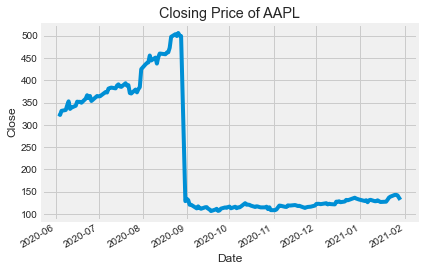

In [15]:
stock["close"].plot()
plt.ylabel("Close")
plt.xlabel("Date")
plt.title(f"Closing Price of {tickerSymbol}")
plt.show()

## Volume Traded

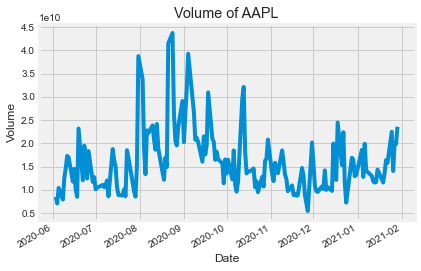

In [16]:
stock["volume"].plot()
plt.ylabel("Volume")
plt.xlabel("Date")
plt.title(f"Volume of {tickerSymbol}")
plt.show()

## Moving Average for Stock

In [17]:
ma_stock = stock.copy()

ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    ma_stock[column_name] = ma_stock['close'].rolling(ma).mean()

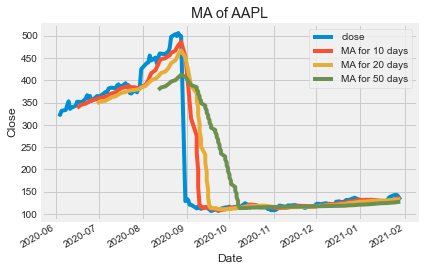

In [18]:
ma_stock[['close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.ylabel("Close")
plt.xlabel("Date")
plt.title(f"MA of {tickerSymbol}")
plt.show()

## Daily Returns of Stock

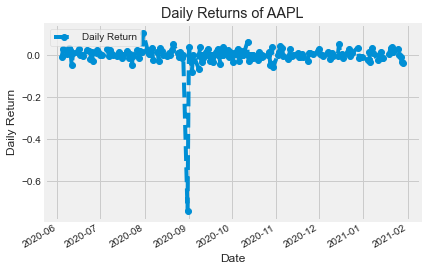

In [19]:
dr_stock = stock.copy()

# pct_change to find the percent change for each day
dr_stock['Daily Return'] = dr_stock['close'].pct_change()

dr_stock['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.ylabel("Daily Return")
plt.xlabel("Date")
plt.title(f"Daily Returns of {tickerSymbol}")
plt.show()

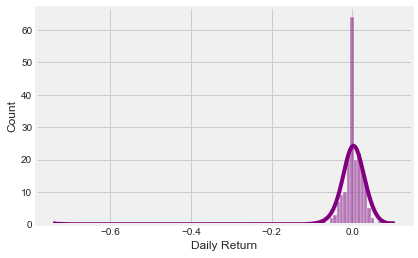

In [20]:
# Average Daily Returns
sns.histplot(dr_stock['Daily Return'].dropna(), bins=100, color='purple', kde=True)
plt.show()

# Data Labeling
Label whether stock price goes up or down.

In [27]:
df = stock.copy()

# Create the target column
df['Price_Up'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)
df = df.drop("symbol", axis=1)
# Show the data
df

,open,high,low,close,volume,turnover,preclose,risefall,risefallratio,Price_Up
date,,,,,,,,,,
2020-06-03,324.66,326.20,322.30,325.12,8.472648e+09,0,323.34,1.78,0.55,0
2020-06-04,324.39,325.62,320.78,322.32,7.077746e+09,0,325.12,-2.80,-0.86,1
2020-06-05,323.35,331.75,323.23,331.50,1.042715e+10,0,322.32,9.18,2.85,1
2020-06-08,330.25,333.60,327.32,333.46,7.917189e+09,0,331.50,1.96,0.59,1
2020-06-09,332.14,345.61,332.01,343.99,1.260915e+10,0,333.46,10.53,3.16,1
...,...,...,...,...,...,...,...,...,...,...
2021-01-25,143.07,145.09,136.54,142.92,2.248438e+10,0,139.07,3.85,2.77,1
2021-01-26,143.60,144.30,141.37,143.16,1.405457e+10,0,142.92,0.24,0.17,0
2021-01-27,143.43,144.30,140.41,142.06,2.008244e+10,0,143.16,-1.10,-0.77,0


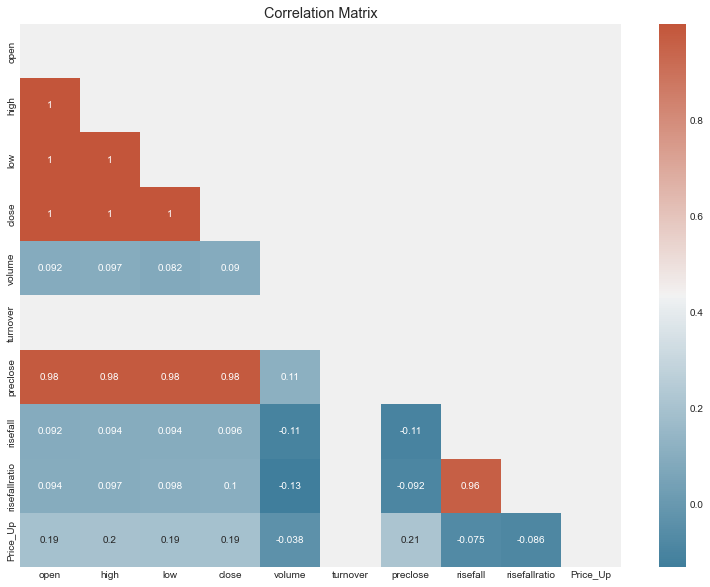

In [29]:
# Correlation between different variables
corr = df.corr()
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.title("Correlation Matrix")
plt.show()

# Data Processing

In [30]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

stock_scaled = pd.DataFrame(scaled_data, columns=df.columns)
stock_scaled

,open,high,low,close,volume,turnover,preclose,risefall,risefallratio,Price_Up
0,0.536551,0.533424,0.551821,0.546725,0.078875,0.0,0.542267,0.906205,0.882770,0.0
1,0.535893,0.531992,0.547995,0.539712,0.042404,0.0,0.546725,0.895047,0.866107,1.0
2,0.533358,0.547129,0.554163,0.562705,0.129976,0.0,0.539712,0.924233,0.909950,1.0
3,0.550177,0.551698,0.564459,0.567614,0.064352,0.0,0.562705,0.906644,0.883243,1.0
4,0.554784,0.581356,0.576266,0.593989,0.187026,0.0,0.567614,0.927522,0.913614,1.0
...,...,...,...,...,...,...,...,...,...,...
195,0.093918,0.086183,0.084183,0.090369,0.445219,0.0,0.080726,0.911248,0.909005,1.0
196,0.095210,0.084233,0.096342,0.090971,0.224817,0.0,0.090369,0.902453,0.878279,0.0
197,0.094796,0.084233,0.093925,0.088215,0.382419,0.0,0.090971,0.899189,0.867171,0.0
198,0.085265,0.078528,0.084586,0.075767,0.376371,0.0,0.088215,0.889761,0.834909,0.0


# Test Train Split

The features are closely related to the time. Therefore, we do not use cross-validation or random splitting here. Otherwise, future information will leak into the training data, and we will get a model that performs very good on the training data but is not useful in predicting future unseen data.

In [41]:
#Split the data set into a feature or independent data set (X) and a target or dependent data set (Y)
X = df.iloc[:, 0:df.shape[1]-1].values
Y = df.iloc[:, df.shape[1]-1].values

In [32]:
#Split the data again but this time into 80% training and 20% testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# Build Model

In [36]:
#Create and train the decision tree Classifier model
tree = DecisionTreeClassifier().fit(X_train, Y_train)

In [39]:
#Check how well the model did on the training data set
print(tree.score(X_train, Y_train))

0.925


In [40]:
#Check how well the model did on the test data set
print(tree.score(X_test, Y_test))

0.5


# Identify feature importance

# Next Steps
- More feature engineering
- Further parameter tuning
- Stacking ensemble ML models